# Project Part 1

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/IrisRuz/CS39AA-AmazonBookReviewIR/blob/main/notebookf684cedf1b.ipynb)


## 1. Introduction/Background

In the digital commerce era, book reviews have become a crucial tool for readers to gauge the quality of a book before purchase.  This project seeks to explore the sentiment expressed in book reviews from a dataset obtained on Kaggle showing the title of the book, the review score, and the text review given.  Using machine learning techniques, I will demonstrate whether reviews reflect positive, neutral, or negative sentiments and explore how they compare with user ratings.  The goal is to develop a model that can recommend books to readers based on their preferences.  

## 2. Exploratory Data Analysis

In [1]:
# import all of the python modules/packages you'll need here
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from collections import Counter
import string
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

> By loading and examining the size of the dataset I am using, I can understand the data's structure better.  

In [2]:
dataset_path = '/kaggle/input/amazon-books-reviews/Books_rating.csv'
df = pd.read_csv(dataset_path)
print(f"df.shape: {df.shape}")
pd.set_option("display.max_colwidth", 240)
df.head()

df.shape: (3000000, 10)


,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,"This is only for Julie Strain fans. It's a collection of her photos -- about 80 pages worth with a nice section of paintings by Olivia.If you're looking for heavy literary content, this isn't the place to find it -- there's only about 2..."
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after reading Philip Nel's book I changed my mind--that's a good testimonial to the power of Rel's writing and thinking. Rel plays Dr. Seuss the ultimate compliment of treating him as a serious poet a...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""the child is father to the man,"" then Dr. Seuss (Theodor Seuss Geisel) is the most influential author, poet, and artist of modern times. For me, a daddy to a large family who learned to read ..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;Dr. Seuss,&quot; was one of the most influential writers and artists of the 20th century.In 1959, Rudolf Flesch wrote, &quot;A hundred years from now, children and their parents will still ea..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,"Philip Nel - Dr. Seuss: American IconThis is basically an academic overview of Seuss poetry, art, cartoons, and the problems with the commercialization of the Seuss name and works after his death. It is not, to any real extent, a biogra..."


> Next, I want to know how many reviews there are for each individual book 

In [3]:
df['Title'].value_counts()

Title
The Hobbit                                                                                                         22023
Pride and Prejudice                                                                                                20371
Atlas Shrugged                                                                                                     12513
Wuthering Heights                                                                                                  10780
The Giver                                                                                                           7644
                                                                                                                   ...  
Illuminatus! Part I: The Eye in the Pyramid (The eye in the Pyramid, The Golden Apple,Leviathan, Parts 1, 2, 3)        1
Modern Chess Openings                                                                                                  1
Child Abuse and Neglect: C

> Given the limited insights from books with only one review, I will filter out titles with fewer than 20 reviews.  

In [4]:
df = df[df.groupby("Title")['Title'].transform("size") > 20]
len(df)

2206794

> Considering the dataset is still rather large I will narrow my analyses to the first 10,000 reviews

In [5]:
df = df.head(10000)

**Preprocessing**

> I will convert the 'review/text' column to a string if not in a string format already.  I will also remove any row that is missing a review

In [6]:
df['review/text'] = df['review/text'].astype(str)
df = df[~df['review/text'].isnull()]
len(df)

10000

> This section will clean the dataset by replacing all special characters with apostrophes

In [7]:
def clean(txt):
    txt = txt.str.replace(r"\(", "")
    txt = txt.str.replace(r'(<a).*(>).*()', '')
    txt = txt.str.replace(r'(&amp)', '')
    txt = txt.str.replace(r'(&gt)', '')
    txt = txt.str.replace(r'(&lt)', '')
    txt = txt.str.replace(r'(\xa0)', ' ')  
    return txt
df['review/text'] = clean(df['review/text'])

> In this section, I will transform all reviews to lowercase to ensure consistency in word count, ensuring each word is counted only once.  

In [8]:
df['review1'] = df['review/text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['review1'].head()

14    i bought this book because i read some glowing praise on an online library site. unfortunately, i was deeply disappointed by page three. i always buy books in the hope and expectation of having an enjoyable read, not to criticise. howev...
15    i have to admit, i am not one to write reviews on book. i do however like to read them. some of the reviews are great, some are cruel, but the reviews on this book were absolutlely hysterical. i read this book and after watching the war...
16    this is a self-published book, and if you want to know why--read a few paragraphs! those 5 star reviews must have been written by ms. haddon's family and friends--or perhaps, by herself! i can't imagine anyone reading the whole thing--i...
17    when i first read this the i was mezmerized at the style of writting. i soon became so hooked on this book that i wanted to fall on my knees and shut out the rest of the world. haddon delivers a portrayal of a woman that is hurt loney a...
18    i read the

> This section will strip all punctuation from the text to help in counting words only once as well

In [9]:
import re

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

df['review1'] = df['review1'].apply(remove_punctuation)
df['review1'].head()

14    i bought this book because i read some glowing praise on an online library site unfortunately i was deeply disappointed by page three i always buy books in the hope and expectation of having an enjoyable read not to criticise however th...
15    i have to admit i am not one to write reviews on book i do however like to read them some of the reviews are great some are cruel but the reviews on this book were absolutlely hysterical i read this book and after watching the war of th...
16    this is a selfpublished book and if you want to know whyread a few paragraphs those 5 star reviews must have been written by ms haddons family and friendsor perhaps by herself i cant imagine anyone reading the whole thingi spent an even...
17    when i first read this the i was mezmerized at the style of writting i soon became so hooked on this book that i wanted to fall on my knees and shut out the rest of the world haddon delivers a portrayal of a woman that is hurt loney and...
18    i read the

> In this part, I will eliminate all stopwords from the reviews to focus on the most meaningful words

In [10]:

nltk.download('stopwords')

stop = stopwords.words('english')
df['review1'] = df['review1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['review1'].head()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


14    bought book read glowing praise online library site unfortunately deeply disappointed page three always buy books hope expectation enjoyable read criticise however book urgent need good editing though quite possibly editing alone wouldn...
15    admit one write reviews book however like read reviews great cruel reviews book absolutlely hysterical read book watching war words couldnt help jump good side book loved kept intersted bad side say typo featured back cover secret likin...
16    selfpublished book want know whyread paragraphs 5 star reviews must written ms haddons family friendsor perhaps cant imagine anyone reading whole thingi spent evening book friend hysterics reading bits pieces one another definitely bad ...
17                                             first read mezmerized style writting soon became hooked book wanted fall knees shut rest world haddon delivers portrayal woman hurt loney abused think wonderful job making reader feel like character
18    read revie

> This section will identify and then remove any words that appear only once in a review. 

In [11]:
freq = pd.Series(' '.join(df['review1']).split()).value_counts()
less_freq = list(freq[freq ==1].index)
first_25_words = less_freq[:25]
print(first_25_words)

['directionthis', 'humorousthis', 'beforehigh', 'shadowing', 'despising', 'duelquot', 'recommanded', 'sunquotmuch', 'talei', 'connectthedots', 'storymy', 'goldstarred', 'enchantedpowers', 'tragedyone', 'pleasently', 'dietake', 'epidemiologic', 'blackbrowed', 'onby', 'enjoyng', 'tybalts', 'soliliquies', 'marraige', 'evry', 'finethat']


In [12]:
df['review1'] = df['review1'].apply(lambda x: " ".join(x for x in x.split() if x not in less_freq))

**Data Analysis**

> Here I will calculate the length of each review by character count and determine the word count by splitting the text into individual words. 

In [13]:
df['review_len'] = df['review/text'].astype(str).apply(len)
df['word_count'] = df['review/text'].apply(lambda x: len(str(x).split()))

> This section of the analysis determines the sentiment of each review categorizing them as positive, neutral, or negative.  

In [14]:
df['polarity'] = df['review1'].map(lambda text: TextBlob(text).sentiment.polarity)
df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text,review1,review_len,word_count,polarity
14,0595344550,Whispers of the Wicked Saints,10.95,A3Q12RK71N74LB,Book Reader,7/11,1.0,1117065600,not good,"I bought this book because I read some glowing praise on an online library site. Unfortunately, I was deeply disappointed by page three. I always buy books in the hope and expectation of having an enjoyable read, not to criticise. Howev...",bought book read glowing praise online library site unfortunately deeply disappointed page three always buy books hope expectation enjoyable read criticise however book urgent need good editing though quite possibly editing alone wouldn...,1025,176,0.025595
15,0595344550,Whispers of the Wicked Saints,10.95,A1E9M6APK30ZAU,V. Powell,1/2,4.0,1119571200,Here is my opinion,"I have to admit, I am not one to write reviews on book. I do however like to read them. Some of the reviews are great, some are cruel, but the reviews on this book were absolutlely hysterical. I read this book and after watching the war...",admit one write reviews book however like read reviews great cruel reviews book absolutlely hysterical read book watching war words couldnt help jump good side book loved kept bad side say typo featured back cover secret liking book mak...,1201,239,-0.062500
16,0595344550,Whispers of the Wicked Saints,10.95,AUR0VA5H0C66C,"LoveToRead ""Actually Read Books""",1/2,1.0,1119225600,Buyer beware,"This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I...",selfpublished book want know paragraphs 5 star reviews must written ms haddons family perhaps cant imagine anyone reading whole spent evening book friend reading bits pieces one another definitely bad enough entered kind worst book cont...,724,137,0.030000
17,0595344550,Whispers of the Wicked Saints,10.95,A1YLDZ3VHR6QPZ,Clara,2/4,5.0,1115942400,Fall on your knee's,When I first read this the I was mezmerized at the style of writting. I soon became so hooked on this book that I wanted to fall on my knees and shut out the rest of the world. Haddon delivers a portrayal of a woman that is hurt loney a...,first read style writting soon became hooked book wanted fall knees shut rest world haddon delivers portrayal woman hurt abused think wonderful job making reader feel like character,325,66,0.625000
18,0595344550,Whispers of the Wicked Saints,10.95,ACO23CG8K8T77,Tonya,5/9,5.0,1117065600,Bravo Veronica,I read the review directly under mine and I have to say I laughed. How can someone write a honest review on a book they read only three pages of? That was funny but also sad that people are mean enough to keep others from an enjoyable r...,read review directly mine say laughed someone write honest review book read three pages funny also sad people mean enough keep others enjoyable read loved book thought first chapter little long read whole book loved book heart right hap...,684,143,0.299320


> This code generates histograms to visualize the distribution of review lengths, word counts, and the sentiment(polarity) of a review.

array([[<Axes: title={'center': 'review_len'}>,
        <Axes: title={'center': 'word_count'}>],
       [<Axes: title={'center': 'polarity'}>, <Axes: >]], dtype=object)

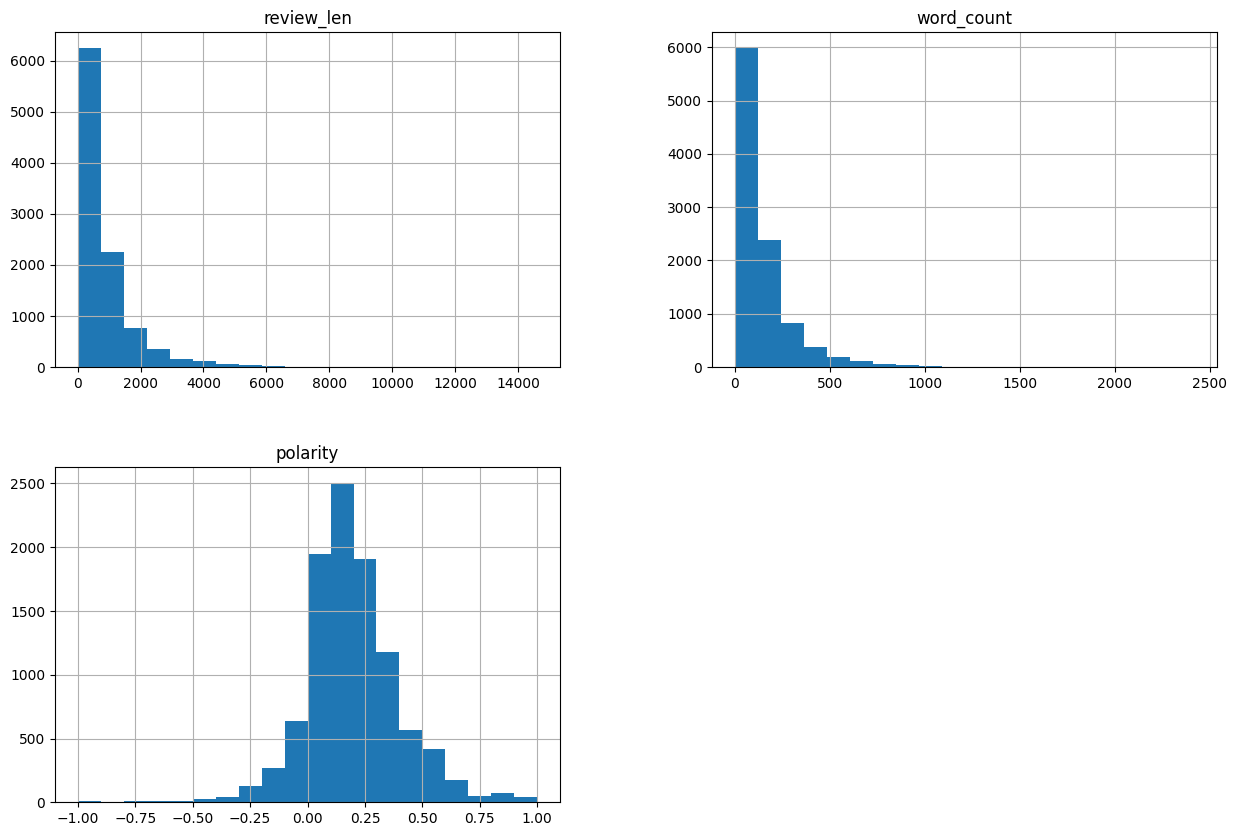

In [15]:
df[["review_len", "word_count", "polarity"]].hist(bins=20, figsize=(15, 10))

> The following box plot will compare polarity with the product ratings given on Amazon    

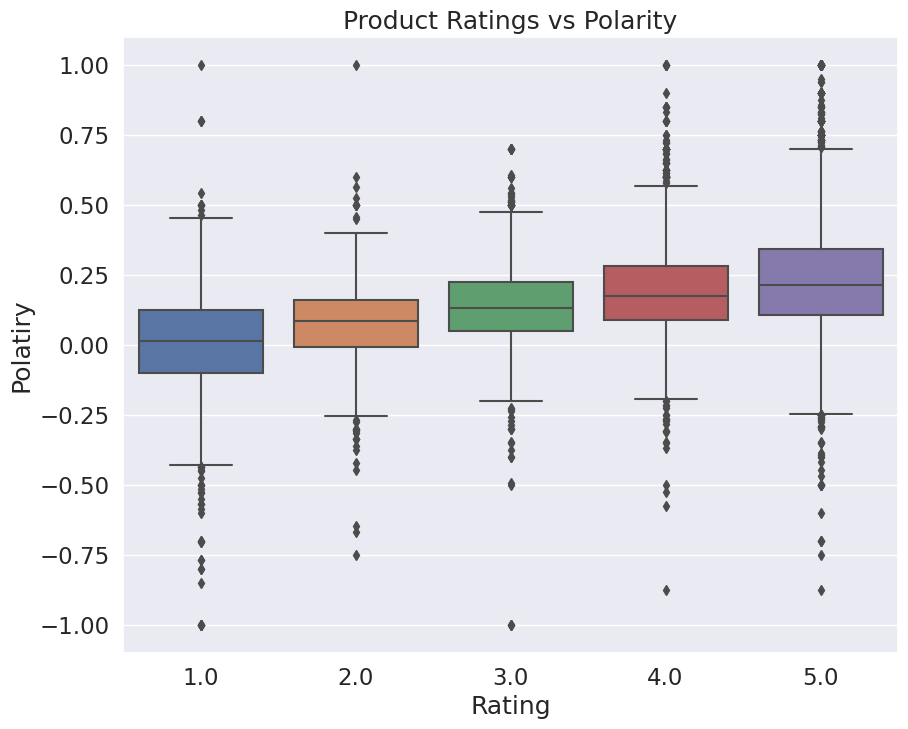

In [16]:

plt.figure(figsize = (10, 8))
sns.set_style('whitegrid')
sns.set(font_scale = 1.5)
sns.boxplot(x = 'review/score', y = 'polarity', data = df)
plt.xlabel("Rating")
plt.ylabel("Polatiry")
plt.title("Product Ratings vs Polarity")
plt.show()

> This bar chart shows the average polarity for reviews grouped by their corresponding Amazon review scores.  

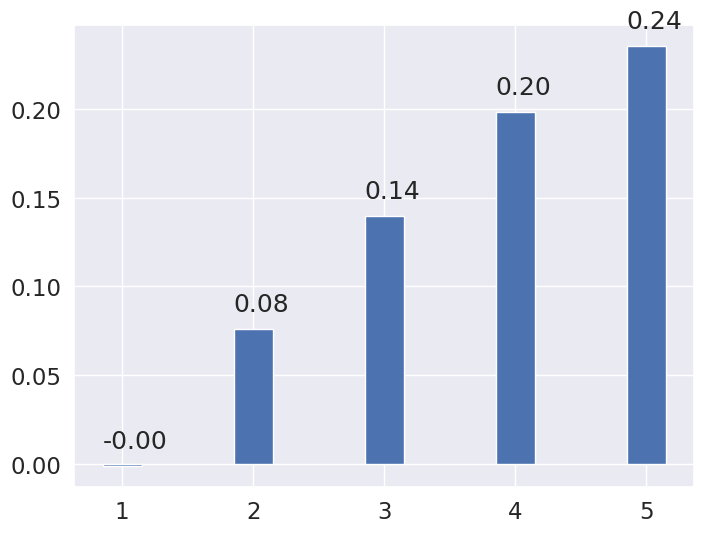

In [17]:
mean_pol = df.groupby('review/score')['polarity'].agg([np.mean])
mean_pol.columns = ['mean_polarity']
fig, ax = plt.subplots(figsize=(8, 6))
plt.bar(mean_pol.index, mean_pol.mean_polarity, width=0.3)
#plt.gca().set_xticklabels(mean_pol.index, fontdict={'size': 14})
for i in ax.patches:
    ax.text(i.get_x(), i.get_height()+0.01, str("{:.2f}".format(i.get_height())))

> Count of the reviews of each rating

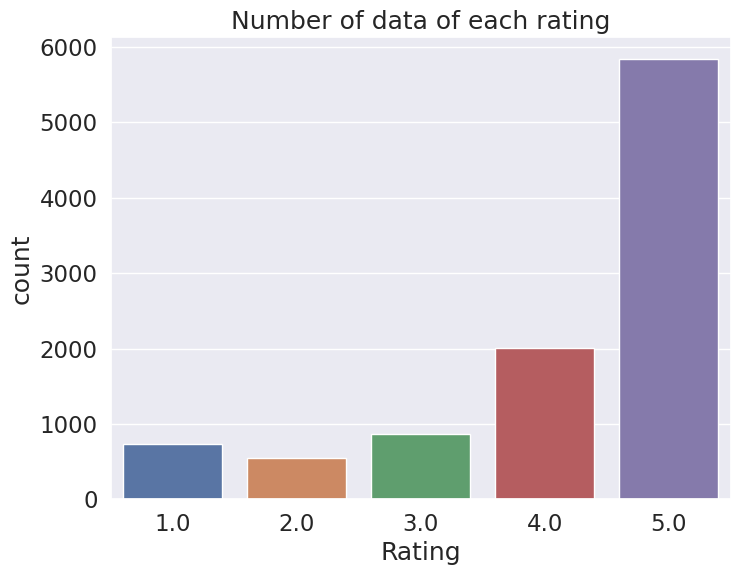

In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x='review/score', data=df)
plt.xlabel("Rating")
plt.title("Number of data of each rating")
plt.show()

> Review length based on rating.  

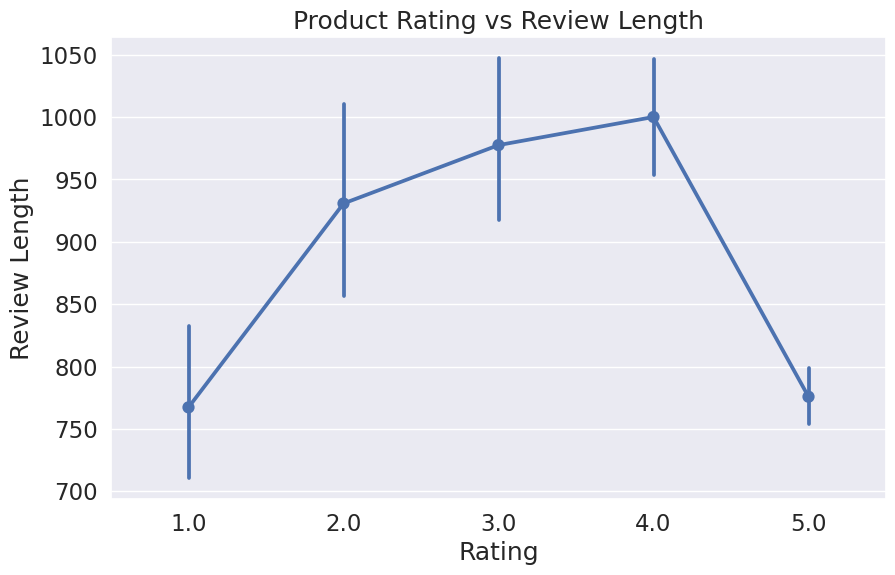

In [19]:
plt.figure(figsize=(10, 6))
sns.pointplot(x = "review/score", y = "review_len", data = df)
plt.xlabel("Rating")
plt.ylabel("Review Length")
plt.title("Product Rating vs Review Length")
plt.show()

> Top 20 books based on polarity

In [20]:
product_pol = df.groupby('Title')['polarity'].agg([np.mean])
product_pol.columns = ['polarity']
product_pol = product_pol.sort_values('polarity', ascending=False)
product_pol = product_pol.head(20)
product_pol

,polarity
Title,
"The Gun Digest Book of the 1911: A Complete Look at the Use, Care & Repair of the 1911 Pistol, Vol. 1",0.356086
Woodcraft,0.354316
Sea Runners,0.331834
Dali,0.329967
Death Dream,0.328833
SPELLBINDER: NIGHTWORLD,0.327522
Alaska Sourdough,0.315574
The Chosen (Night World),0.313212
Sweet Hush: A Novel,0.312110


> Top most occurring words in the reviews

In [21]:

def get_top_n_words(corpus, n=None):
    vec=CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['review1'], 20)
df1 = pd.DataFrame(common_words, columns = ['Review', 'count'])
df1.head()

,Review,count
0,book,18047
1,read,8163
2,one,6190
3,story,4152
4,like,3817
